# Lab | Data Aggregation and Filtering

In this challenge, we will continue to work with customer data from an insurance company. We will use the dataset called marketing_customer_analysis.csv, which can be found at the following link:

https://raw.githubusercontent.com/data-bootcamp-v4/data/main/marketing_customer_analysis.csv

This dataset contains information such as customer demographics, policy details, vehicle information, and the customer's response to the last marketing campaign. Our goal is to explore and analyze this data by first performing data cleaning, formatting, and structuring.

1. Create a new DataFrame that only includes customers who have a total_claim_amount greater than $1,000 and have a response of "Yes" to the last marketing campaign.

2. Using the original Dataframe, analyze the average total_claim_amount by each policy type and gender for customers who have responded "Yes" to the last marketing campaign. Write your conclusions.

3. Analyze the total number of customers who have policies in each state, and then filter the results to only include states where there are more than 500 customers.

4. Find the maximum, minimum, and median customer lifetime value by education level and gender. Write your conclusions.

## Bonus

5. The marketing team wants to analyze the number of policies sold by state and month. Present the data in a table where the months are arranged as columns and the states are arranged as rows.

6.  Display a new DataFrame that contains the number of policies sold by month, by state, for the top 3 states with the highest number of policies sold.

*Hint:*
- *To accomplish this, you will first need to group the data by state and month, then count the number of policies sold for each group. Afterwards, you will need to sort the data by the count of policies sold in descending order.*
- *Next, you will select the top 3 states with the highest number of policies sold.*
- *Finally, you will create a new DataFrame that contains the number of policies sold by month for each of the top 3 states.*

7. The marketing team wants to analyze the effect of different marketing channels on the customer response rate.

Hint: You can use melt to unpivot the data and create a table that shows the customer response rate (those who responded "Yes") by marketing channel.

External Resources for Data Filtering: https://towardsdatascience.com/filtering-data-frames-in-pandas-b570b1f834b9

In [34]:
# your code goes here
import pandas as pd

mark_cust_df = pd.read_csv("https://raw.githubusercontent.com/data-bootcamp-v4/data/main/marketing_customer_analysis.csv")
mark_cust_df.head()

,Unnamed: 0,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,...,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size,Vehicle Type
0,0,DK49336,Arizona,4809.216960,No,Basic,College,2/18/11,Employed,M,...,0.0,9,Corporate Auto,Corporate L3,Offer3,Agent,292.800000,Four-Door Car,Medsize,NaN
1,1,KX64629,California,2228.525238,No,Basic,College,1/18/11,Unemployed,F,...,0.0,1,Personal Auto,Personal L3,Offer4,Call Center,744.924331,Four-Door Car,Medsize,NaN
2,2,LZ68649,Washington,14947.917300,No,Basic,Bachelor,2/10/11,Employed,M,...,0.0,2,Personal Auto,Personal L3,Offer3,Call Center,480.000000,SUV,Medsize,A
3,3,XL78013,Oregon,22332.439460,Yes,Extended,College,1/11/11,Employed,M,...,0.0,2,Corporate Auto,Corporate L3,Offer2,Branch,484.013411,Four-Door Car,Medsize,A
4,4,QA50777,Oregon,9025.067525,No,Premium,Bachelor,1/17/11,Medical Leave,F,...,NaN,7,Personal Auto,Personal L2,Offer1,Branch,707.925645,Four-Door Car,Medsize,NaN


In [35]:
mark_cust_df.shape

(10910, 26)

In [36]:
mark_cust_df.dtypes

Unnamed: 0                         int64
Customer                          object
State                             object
Customer Lifetime Value          float64
Response                          object
Coverage                          object
Education                         object
Effective To Date                 object
EmploymentStatus                  object
Gender                            object
Income                             int64
Location Code                     object
Marital Status                    object
Monthly Premium Auto               int64
Months Since Last Claim          float64
Months Since Policy Inception      int64
Number of Open Complaints        float64
Number of Policies                 int64
Policy Type                       object
Policy                            object
Renew Offer Type                  object
Sales Channel                     object
Total Claim Amount               float64
Vehicle Class                     object
Vehicle Size    

In [37]:
mark_cust_df.nunique()

Unnamed: 0                       10910
Customer                          9134
State                                5
Customer Lifetime Value           8041
Response                             2
Coverage                             3
Education                            5
Effective To Date                   59
EmploymentStatus                     5
Gender                               2
Income                            5694
Location Code                        3
Marital Status                       3
Monthly Premium Auto               202
Months Since Last Claim             36
Months Since Policy Inception      100
Number of Open Complaints            6
Number of Policies                   9
Policy Type                          3
Policy                               9
Renew Offer Type                     4
Sales Channel                        4
Total Claim Amount                5106
Vehicle Class                        6
Vehicle Size                         3
Vehicle Type             

In [38]:
print(mark_cust_df.columns.tolist())

['Unnamed: 0', 'Customer', 'State', 'Customer Lifetime Value', 'Response', 'Coverage', 'Education', 'Effective To Date', 'EmploymentStatus', 'Gender', 'Income', 'Location Code', 'Marital Status', 'Monthly Premium Auto', 'Months Since Last Claim', 'Months Since Policy Inception', 'Number of Open Complaints', 'Number of Policies', 'Policy Type', 'Policy', 'Renew Offer Type', 'Sales Channel', 'Total Claim Amount', 'Vehicle Class', 'Vehicle Size', 'Vehicle Type']


In [39]:
print(type(mark_cust_df))

<class 'pandas.core.frame.DataFrame'>


In [40]:
mark_cust_df.columns = mark_cust_df.columns.str.strip().str.lower().str.replace(' ', '_', regex=False)
mark_cust_df

,unnamed:_0,customer,state,customer_lifetime_value,response,coverage,education,effective_to_date,employmentstatus,gender,...,number_of_open_complaints,number_of_policies,policy_type,policy,renew_offer_type,sales_channel,total_claim_amount,vehicle_class,vehicle_size,vehicle_type
0,0,DK49336,Arizona,4809.216960,No,Basic,College,2/18/11,Employed,M,...,0.0,9,Corporate Auto,Corporate L3,Offer3,Agent,292.800000,Four-Door Car,Medsize,NaN
1,1,KX64629,California,2228.525238,No,Basic,College,1/18/11,Unemployed,F,...,0.0,1,Personal Auto,Personal L3,Offer4,Call Center,744.924331,Four-Door Car,Medsize,NaN
2,2,LZ68649,Washington,14947.917300,No,Basic,Bachelor,2/10/11,Employed,M,...,0.0,2,Personal Auto,Personal L3,Offer3,Call Center,480.000000,SUV,Medsize,A
3,3,XL78013,Oregon,22332.439460,Yes,Extended,College,1/11/11,Employed,M,...,0.0,2,Corporate Auto,Corporate L3,Offer2,Branch,484.013411,Four-Door Car,Medsize,A
4,4,QA50777,Oregon,9025.067525,No,Premium,Bachelor,1/17/11,Medical Leave,F,...,NaN,7,Personal Auto,Personal L2,Offer1,Branch,707.925645,Four-Door Car,Medsize,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10905,10905,FE99816,Nevada,15563.369440,No,Premium,Bachelor,1/19/11,Unemployed,F,...,NaN,7,Personal Auto,Personal L1,Offer3,Web,1214.400000,Luxury Car,Medsize,A
10906,10906,KX53892,Oregon,5259.444853,No,Basic,College,1/6/11,Employed,F,...,0.0,6,Personal Auto,Personal L3,Offer2,Branch,273.018929,Four-Door Car,Medsize,A
10907,10907,TL39050,Arizona,23893.304100,No,Extended,Bachelor,2/6/11,Employed,F,...,0.0,2,Corporate Auto,Corporate L3,Offer1,Web,381.306996,Luxury SUV,Medsize,NaN
10908,10908,WA60547,California,11971.977650,No,Premium,College,2/13/11,Employed,F,...,4.0,6,Personal Auto,Personal L1,Offer1,Branch,618.288849,SUV,Medsize,A


In [41]:
print(type(mark_cust_df))

<class 'pandas.core.frame.DataFrame'>


In [42]:
mark_cust_df = mark_cust_df.rename(columns={"unnamed:_0": "index", "employmentstatus": "employment_status"})
mark_cust_df

,index,customer,state,customer_lifetime_value,response,coverage,education,effective_to_date,employment_status,gender,...,number_of_open_complaints,number_of_policies,policy_type,policy,renew_offer_type,sales_channel,total_claim_amount,vehicle_class,vehicle_size,vehicle_type
0,0,DK49336,Arizona,4809.216960,No,Basic,College,2/18/11,Employed,M,...,0.0,9,Corporate Auto,Corporate L3,Offer3,Agent,292.800000,Four-Door Car,Medsize,NaN
1,1,KX64629,California,2228.525238,No,Basic,College,1/18/11,Unemployed,F,...,0.0,1,Personal Auto,Personal L3,Offer4,Call Center,744.924331,Four-Door Car,Medsize,NaN
2,2,LZ68649,Washington,14947.917300,No,Basic,Bachelor,2/10/11,Employed,M,...,0.0,2,Personal Auto,Personal L3,Offer3,Call Center,480.000000,SUV,Medsize,A
3,3,XL78013,Oregon,22332.439460,Yes,Extended,College,1/11/11,Employed,M,...,0.0,2,Corporate Auto,Corporate L3,Offer2,Branch,484.013411,Four-Door Car,Medsize,A
4,4,QA50777,Oregon,9025.067525,No,Premium,Bachelor,1/17/11,Medical Leave,F,...,NaN,7,Personal Auto,Personal L2,Offer1,Branch,707.925645,Four-Door Car,Medsize,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10905,10905,FE99816,Nevada,15563.369440,No,Premium,Bachelor,1/19/11,Unemployed,F,...,NaN,7,Personal Auto,Personal L1,Offer3,Web,1214.400000,Luxury Car,Medsize,A
10906,10906,KX53892,Oregon,5259.444853,No,Basic,College,1/6/11,Employed,F,...,0.0,6,Personal Auto,Personal L3,Offer2,Branch,273.018929,Four-Door Car,Medsize,A
10907,10907,TL39050,Arizona,23893.304100,No,Extended,Bachelor,2/6/11,Employed,F,...,0.0,2,Corporate Auto,Corporate L3,Offer1,Web,381.306996,Luxury SUV,Medsize,NaN
10908,10908,WA60547,California,11971.977650,No,Premium,College,2/13/11,Employed,F,...,4.0,6,Personal Auto,Personal L1,Offer1,Branch,618.288849,SUV,Medsize,A


In [43]:
mark_cust_df["effective_to_date"].value_counts()

effective_to_date
1/10/11    239
1/27/11    239
1/31/11    224
1/17/11    221
2/14/11    221
1/26/11    220
1/3/11     216
1/19/11    212
2/27/11    205
1/28/11    203
2/26/11    202
1/20/11    201
1/21/11    199
2/4/11     198
2/7/11     197
2/19/11    196
2/3/11     195
1/11/11    195
1/5/11     193
2/28/11    192
2/22/11    191
1/2/11     191
2/18/11    186
2/10/11    186
2/11/11    184
1/23/11    184
2/12/11    183
1/18/11    183
2/25/11    183
1/8/11     182
1/29/11    182
1/9/11     182
2/5/11     181
2/1/11     181
2/2/11     181
2/9/11     180
1/14/11    180
1/24/11    179
2/21/11    178
1/7/11     178
2/23/11    176
1/30/11    173
1/15/11    172
1/16/11    172
1/13/11    171
1/1/11     171
2/6/11     171
1/25/11    168
2/13/11    168
2/16/11    167
2/24/11    162
2/17/11    162
1/6/11     161
2/20/11    156
2/15/11    155
2/8/11     155
1/22/11    148
1/12/11    148
1/4/11     131
Name: count, dtype: int64

In [44]:
# changing the format of the date

mark_cust_df["effective_to_date"] = pd.to_datetime(mark_cust_df["effective_to_date"], format="%m/%d/%y", errors="coerce")
mark_cust_df


,index,customer,state,customer_lifetime_value,response,coverage,education,effective_to_date,employment_status,gender,...,number_of_open_complaints,number_of_policies,policy_type,policy,renew_offer_type,sales_channel,total_claim_amount,vehicle_class,vehicle_size,vehicle_type
0,0,DK49336,Arizona,4809.216960,No,Basic,College,2011-02-18,Employed,M,...,0.0,9,Corporate Auto,Corporate L3,Offer3,Agent,292.800000,Four-Door Car,Medsize,NaN
1,1,KX64629,California,2228.525238,No,Basic,College,2011-01-18,Unemployed,F,...,0.0,1,Personal Auto,Personal L3,Offer4,Call Center,744.924331,Four-Door Car,Medsize,NaN
2,2,LZ68649,Washington,14947.917300,No,Basic,Bachelor,2011-02-10,Employed,M,...,0.0,2,Personal Auto,Personal L3,Offer3,Call Center,480.000000,SUV,Medsize,A
3,3,XL78013,Oregon,22332.439460,Yes,Extended,College,2011-01-11,Employed,M,...,0.0,2,Corporate Auto,Corporate L3,Offer2,Branch,484.013411,Four-Door Car,Medsize,A
4,4,QA50777,Oregon,9025.067525,No,Premium,Bachelor,2011-01-17,Medical Leave,F,...,NaN,7,Personal Auto,Personal L2,Offer1,Branch,707.925645,Four-Door Car,Medsize,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10905,10905,FE99816,Nevada,15563.369440,No,Premium,Bachelor,2011-01-19,Unemployed,F,...,NaN,7,Personal Auto,Personal L1,Offer3,Web,1214.400000,Luxury Car,Medsize,A
10906,10906,KX53892,Oregon,5259.444853,No,Basic,College,2011-01-06,Employed,F,...,0.0,6,Personal Auto,Personal L3,Offer2,Branch,273.018929,Four-Door Car,Medsize,A
10907,10907,TL39050,Arizona,23893.304100,No,Extended,Bachelor,2011-02-06,Employed,F,...,0.0,2,Corporate Auto,Corporate L3,Offer1,Web,381.306996,Luxury SUV,Medsize,NaN
10908,10908,WA60547,California,11971.977650,No,Premium,College,2011-02-13,Employed,F,...,4.0,6,Personal Auto,Personal L1,Offer1,Branch,618.288849,SUV,Medsize,A


In [46]:
mark_cust_df.duplicated().sum()

0

In [48]:
cols_to_check = ["state", "response", "coverage", "education", "employment_status", "marital_status", "monthly_premium_auto", "months_since_last_claim", "months_since_policy_inception", "number_of_open_complaints", "number_of_policies"]

for col in cols_to_check:
    print(f"\n--- {col.upper()} ---")
    print(mark_cust_df[col].value_counts(dropna=False))


--- STATE ---
state
California    3552
Oregon        2909
Arizona       1937
Nevada         993
Washington     888
NaN            631
Name: count, dtype: int64

--- RESPONSE ---
response
No     8813
Yes    1466
NaN     631
Name: count, dtype: int64

--- COVERAGE ---
coverage
Basic       6660
Extended    3265
Premium      985
Name: count, dtype: int64

--- EDUCATION ---
education
Bachelor                3272
College                 3204
High School or Below    3146
Master                   887
Doctor                   401
Name: count, dtype: int64

--- EMPLOYMENT_STATUS ---
employment_status
Employed         6789
Unemployed       2787
Medical Leave     504
Disabled          499
Retired           331
Name: count, dtype: int64

--- MARITAL_STATUS ---
marital_status
Married     6319
Single      2958
Divorced    1633
Name: count, dtype: int64

--- MONTHLY_PREMIUM_AUTO ---
monthly_premium_auto
65     419
66     371
71     368
73     363
63     345
      ... 
163      1
178      1
287      1

In [50]:
mark_cust_df["vehicle_class"] = mark_cust_df["vehicle_class"].replace({"Luxury SUV" : "Luxury", "Luxury Car" : "Luxury","Sports Car" : "Luxury"})
mark_cust_df["vehicle_class"].value_counts()

vehicle_class
Four-Door Car    5212
Two-Door Car     2118
SUV              2012
Luxury            946
Name: count, dtype: int64

In [51]:
mark_cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10910 entries, 0 to 10909
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   index                          10910 non-null  int64         
 1   customer                       10910 non-null  object        
 2   state                          10279 non-null  object        
 3   customer_lifetime_value        10910 non-null  float64       
 4   response                       10279 non-null  object        
 5   coverage                       10910 non-null  object        
 6   education                      10910 non-null  object        
 7   effective_to_date              10910 non-null  datetime64[ns]
 8   employment_status              10910 non-null  object        
 9   gender                         10910 non-null  object        
 10  income                         10910 non-null  int64         
 11  location_code  

In [53]:
# 1. Create a new DataFrame that only includes customers who have a total_claim_amount greater than $1,000 
# and have a response of "Yes" to the last marketing campaign.

new_df = mark_cust_df[(mark_cust_df["total_claim_amount"] > 1_000) & (mark_cust_df["response"] == "Yes")]
new_df

,index,customer,state,customer_lifetime_value,response,coverage,education,effective_to_date,employment_status,gender,...,number_of_open_complaints,number_of_policies,policy_type,policy,renew_offer_type,sales_channel,total_claim_amount,vehicle_class,vehicle_size,vehicle_type
189,189,OK31456,California,11009.130490,Yes,Premium,Bachelor,2011-01-24,Employed,F,...,0.0,1,Corporate Auto,Corporate L3,Offer2,Agent,1358.400000,Luxury,Medsize,NaN
236,236,YJ16163,Oregon,11009.130490,Yes,Premium,Bachelor,2011-01-24,Employed,F,...,0.0,1,Special Auto,Special L3,Offer2,Agent,1358.400000,Luxury,Medsize,A
419,419,GW43195,Oregon,25807.063000,Yes,Extended,College,2011-02-13,Employed,F,...,1.0,2,Personal Auto,Personal L2,Offer1,Branch,1027.200000,Luxury,Small,A
442,442,IP94270,Arizona,13736.132500,Yes,Premium,Master,2011-02-13,Disabled,F,...,0.0,8,Personal Auto,Personal L2,Offer1,Web,1261.319869,SUV,Medsize,A
587,587,FJ28407,California,5619.689084,Yes,Premium,High School or Below,2011-01-26,Unemployed,M,...,0.0,1,Personal Auto,Personal L1,Offer2,Web,1027.000029,SUV,Medsize,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10351,10351,FN44127,Oregon,3508.569533,Yes,Extended,College,2011-01-05,Medical Leave,M,...,1.0,1,Personal Auto,Personal L2,Offer2,Branch,1176.278800,Four-Door Car,Small,NaN
10373,10373,XZ64172,Oregon,10963.957230,Yes,Premium,High School or Below,2011-02-08,Employed,M,...,0.0,1,Corporate Auto,Corporate L2,Offer1,Agent,1324.800000,Luxury,Medsize,NaN
10487,10487,IX60941,Oregon,3508.569533,Yes,Extended,College,2011-01-05,Medical Leave,M,...,1.0,1,Personal Auto,Personal L3,Offer2,Branch,1176.278800,Four-Door Car,Small,NaN
10565,10565,QO62792,Oregon,7840.165778,Yes,Extended,College,2011-01-14,Employed,M,...,2.0,1,Personal Auto,Personal L3,Offer2,Agent,1008.000000,NaN,NaN,NaN


In [57]:
new_df["total_claim_amount"].describe()

count      67.000000
mean     1176.368262
std       138.315227
min      1008.000000
25%      1027.200000
50%      1176.278800
75%      1300.800000
max      1358.400000
Name: total_claim_amount, dtype: float64

In [58]:
# 2. Using the original Dataframe, analyze the average total_claim_amount by each policy type and gender for customers who have responded "Yes" to the last marketing campaign. Write your conclusions.
responded_df = mark_cust_df[mark_cust_df["response"].str.strip().str.lower() == "yes"]

avg_claims = (
    responded_df
    .groupby(["policy_type", "gender"])["total_claim_amount"]
    .mean()
    .reset_index()
    .round(2)
)

print(avg_claims)

# Conclusions: among customers who responded positively to the campaing, Personal Auto policies show 
# the highest average claim amounts, suggestiing they are both responsive and high-value.
# gender differences are minimal

      policy_type gender  total_claim_amount
0  Corporate Auto      F              433.74
1  Corporate Auto      M              408.58
2   Personal Auto      F              452.97
3   Personal Auto      M              457.01
4    Special Auto      F              453.28
5    Special Auto      M              429.53


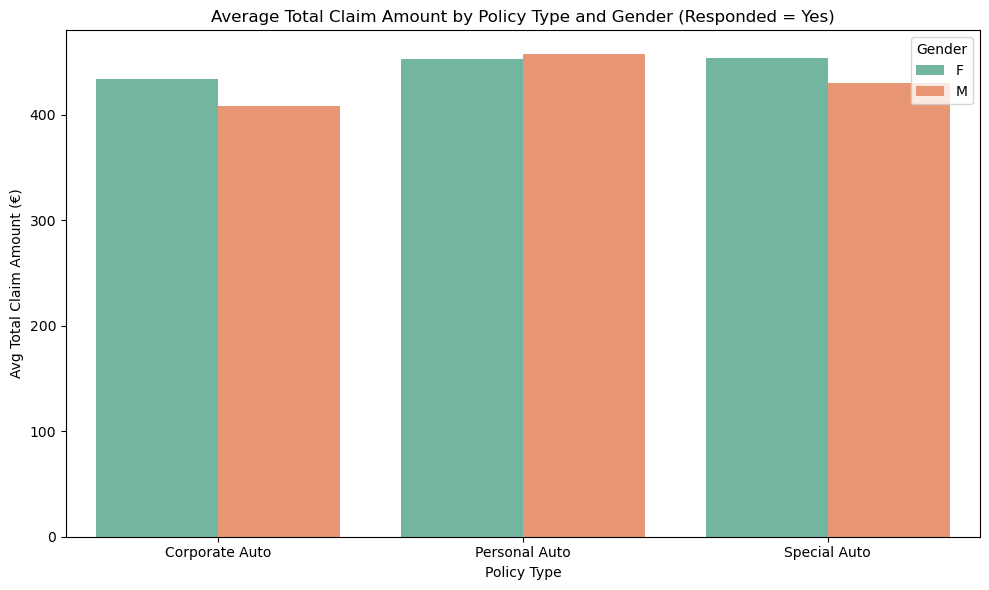

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

sns.barplot(
    data=avg_claims,
    x="policy_type",
    y="total_claim_amount",
    hue="gender",
    palette="Set2"
)

plt.title("Average Total Claim Amount by Policy Type and Gender (Responded = Yes)")
plt.xlabel("Policy Type")
plt.ylabel("Avg Total Claim Amount (€)")
plt.legend(title="Gender")
plt.tight_layout()
plt.show()

In [60]:
# 3. Analyze the total number of customers who have policies in each state, and then filter the results to only include states where there are more than 500 customers.

# count the number of clients by state
state_counts = mark_cust_df["state"].value_counts()

# filter for states with more than 500 customers
filtered_states = state_counts[state_counts > 500]

print(filtered_states)


state
California    3552
Oregon        2909
Arizona       1937
Nevada         993
Washington     888
Name: count, dtype: int64


In [63]:
mark_cust_df["customer_lifetime_value"] = pd.to_numeric(mark_cust_df["customer_lifetime_value"], errors="coerce")

min_max_mean = (
    mark_cust_df
    .groupby(["education", "gender"])["customer_lifetime_value"]
    .mean()
    .reset_index()
    .round(2)
)

clv_min = min_max_mean["customer_lifetime_value"].min()
clv_max = min_max_mean["customer_lifetime_value"].max()

print("Grouped averages:\n", min_max_mean)
print(f"\nMin CLV: {clv_min}")
print(f"\nMax CLV: {clv_max}")

Grouped averages:
               education gender  customer_lifetime_value
0              Bachelor      F                  7874.27
1              Bachelor      M                  7703.60
2               College      F                  7748.82
3               College      M                  8052.46
4                Doctor      F                  7328.51
5                Doctor      M                  7415.33
6  High School or Below      F                  8675.22
7  High School or Below      M                  8149.69
8                Master      F                  8157.05
9                Master      M                  8168.83

Min CLV: 7328.51

Max CLV: 8675.22


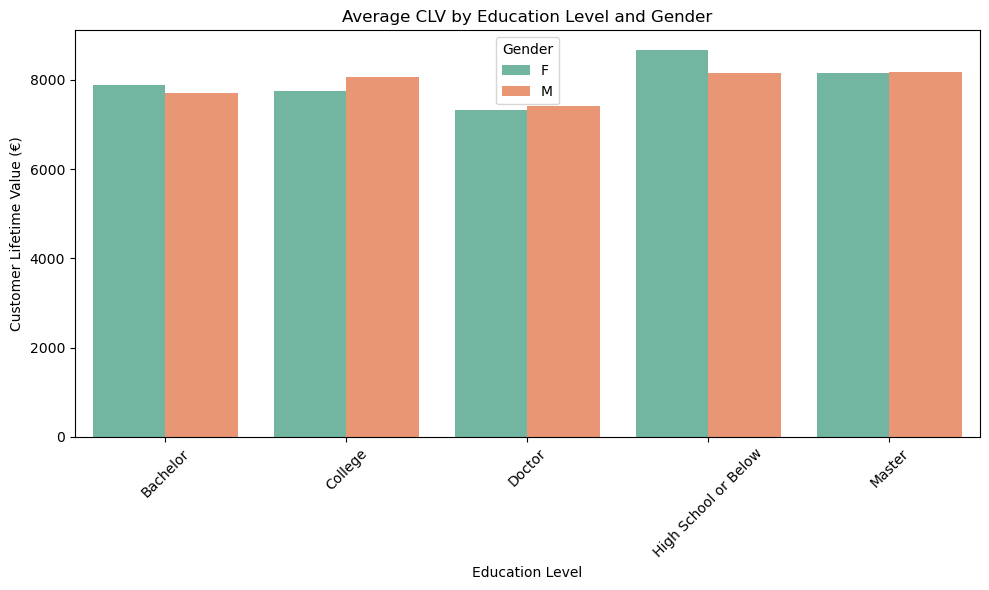

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(
    data=min_max_mean,
    x="education",
    y="customer_lifetime_value",
    hue="gender",
    palette="Set2"
)

plt.title("Average CLV by Education Level and Gender")
plt.xlabel("Education Level")
plt.ylabel("Customer Lifetime Value (€)")
plt.xticks(rotation=45)
plt.legend(title="Gender")
plt.tight_layout()
plt.show()


# altough there is not a great difference between categories, 
# we can see that people (either F or M) with a lower education 
# tend to better customers than those with higher education. 
# This can mean that those with higher education can negotiate better deals 
# or have less incidents 

In [65]:
# 5. The marketing team wants to analyze the number of policies sold by state and month. Present the data in a table where the months are arranged as columns and the states are arranged as rows.

mark_cust_df["effective_to_date"] = pd.to_datetime(mark_cust_df["effective_to_date"], errors="coerce")
mark_cust_df["month"] = mark_cust_df["effective_to_date"].dt.month_name()

policies_by_state_month = mark_cust_df.pivot_table(
    index="state",
    columns="month",
    values="policy",
    aggfunc="count"
).fillna(0).astype(int)

from pandas.api.types import CategoricalDtype

month_order = ["January", "February", "March", "April", "May", "June",
               "July", "August", "September", "October", "November", "December"]

policies_by_state_month.columns = pd.CategoricalIndex(
    policies_by_state_month.columns,
    categories=month_order,
    ordered=True
)
policies_by_state_month = policies_by_state_month.sort_index(axis=1)

print(policies_by_state_month)

month       January  February
state                        
Arizona        1008       929
California     1918      1634
Nevada          551       442
Oregon         1565      1344
Washington      463       425


In [66]:
#6.  Display a new DataFrame that contains the number of policies sold by month, by state, for the top 3 states with the highest number of policies sold.

total_policies_by_states = mark_cust_df["state"].value_counts()

top_3_states = total_policies_by_states.head(3).index.tolist()

filter_df = mark_cust_df[mark_cust_df["state"].isin(top_3_states)]

top_states_summary = (
    filter_df
    .groupby(["state", "month"])
    .size()
    .reset_index(name="policies_sold")
)

top_states_summary["month"] = top_states_summary["month"].astype(CategoricalDtype(categories=month_order, ordered=True))

top_states_summary = top_states_summary.sort_values(["state", "month"])

print(top_states_summary)

        state     month  policies_sold
1     Arizona   January           1008
0     Arizona  February            929
3  California   January           1918
2  California  February           1634
5      Oregon   January           1565
4      Oregon  February           1344


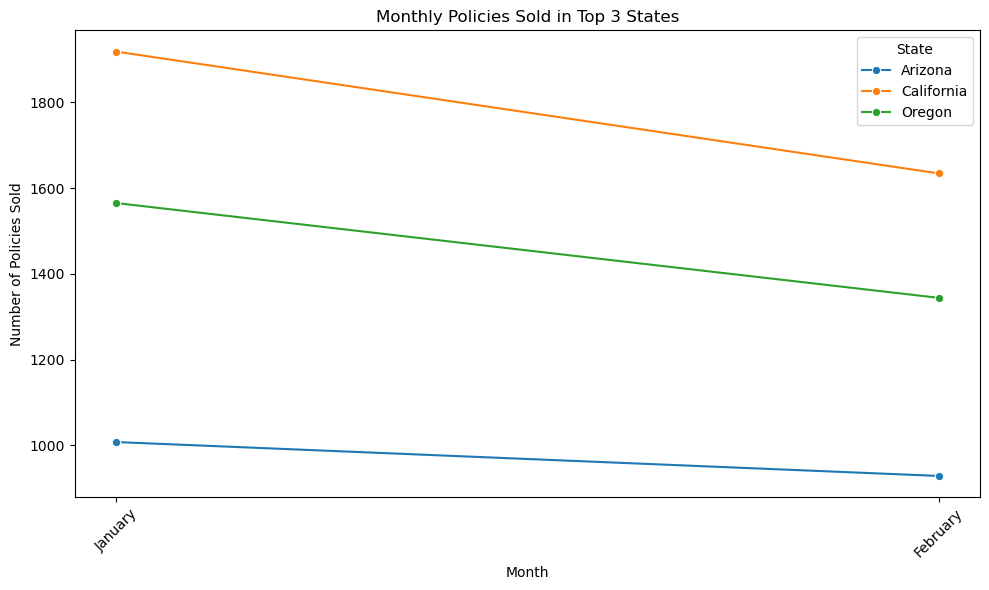

In [67]:
plt.figure(figsize=(10, 6))

sns.lineplot(
    data=top_states_summary,
    x="month",
    y="policies_sold",
    hue="state",
    marker="o"
)

plt.title("Monthly Policies Sold in Top 3 States")
plt.xlabel("Month")
plt.ylabel("Number of Policies Sold")
plt.xticks(rotation=45)
plt.legend(title="State")
plt.tight_layout()
plt.show()